**Perry Fox  
Capstone Notebook 3  
pyrus277@gmail.com  
December 12, 2022** 

---

# Climate and Qualitative Trends in the California Wine Industry
## Part 3: Modeling

---

### Contents: 
1. [Purpose](#p)
1. [Most Pronounced and Statistically Significant Climate Trends](#ss)
1. [Forecasting Future Production Metrics](#fp)
1. [Review Scores and Flavor Descriptors](#pts)


---

<a id="p"></a>
## 1. Purpose

When exploring which climate features had the greatest effect wine production and value, the correlation matrices we saw for the data as a whole were not very interesting.  
However, for some counties, certain features did hold a distinct weight.  

In this notebook I'll first take a more statistical approach to the climate trends explored in the previous notebook to see which are most significant. 

Next, I'll see if these climate trends can be used to predict the production and volume for individual counties, with a focus on the ones we determined to be more sensitive to climate features.

Last, we aim to use the tokenized flavor desriptors we isolated to see if we can predict if a wine will score a high review.

In [5]:
import numpy as np
import pandas as pd
import shelve
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [6]:
# Note- it's no longer called fbprophet. Guess they dropped the fb when they changed to Meta. 
from prophet import Prophet 

In [7]:
# Bring in the wrangled and cleaned data
with shelve.open('capstone_dataframes') as shelfFile:
    cwp = shelfFile['cwp2']
    acc = shelfFile['all_county_climates']
    rev = shelfFile['reviews']

---

<a id="ss"></a>
### 2. Which climate trends are most pronounced and statistically significant?

In [8]:
# Pull the counties that have at least 25 years of production
counties = cwp.groupby(['county']).count()['year']
counties = counties[counties >= 25]
counties = list(counties.index)

Here, we'll run a linear regression model on the various climate features to examine their strength and significance. 

In [9]:
# Initialize statistic lists to use to make a dataframe
feature = []
coef = []
pval = []
R_sq = []

# Collect the statistics for each climate feature
for col in acc.columns[2:]:
    X_withconstant = sm.add_constant(acc['year'])
    y = acc[col]
    
    # Instantiate Linear regression model
    myregression = sm.OLS(y, X_withconstant)
    # Fit the model
    myregression_results = myregression.fit()
    # collect metrics
    feature.append(col)
    coef.append(myregression_results.params[1])
    pval.append(round(myregression_results.pvalues[1],4))
    R_sq.append(myregression_results.rsquared)

# myregression_results.summary()

In [10]:
# Put it in a dataframe so we can summarize
data = {'Feature Over Time': feature,
        'Coefficient': coef,
        'P-Value': pval,
        'R-Squared': R_sq}
climate_stats = pd.DataFrame(data)

#### Here are the most pronounced climate trends for California's vineyard land area:

In [11]:
climate_stats.sort_values('R-Squared', ascending=False).head(10)

,Feature Over Time,Coefficient,P-Value,R-Squared
16,winter_surface_moisture,-0.001489,0.0000,0.022379
5,annual_temperature,0.025518,0.0000,0.018032
11,summer_humidity,0.011095,0.0000,0.016530
19,winter_temperature,0.028089,0.0000,0.015777
17,winter_precipitation,-0.016591,0.0000,0.013417
2,annual_surface_moisture,-0.000996,0.0000,0.012270
3,annual_precipitation,-0.008811,0.0000,0.011683
12,summer_temperature,0.022918,0.0001,0.009755
15,winter_root_moisture,-0.000833,0.0001,0.009153
14,winter_profile_moisture,-0.000765,0.0002,0.008595


For the heck of it, I'll throw everything into Scikit-Learn's model to try a multiple linear regression and see if anything interesting comes out when we ask:  
#### What is the relationship between production in tons and annual climate measures?

In [12]:
# Merge the climate and production dataframes by year and county
cwp_acc = cwp.merge(acc, on = ['year','county'], how = 'inner')
# grab the county list
counties = cwp.county.unique()
# As we saw in the Wrangling notebook, there's a few null values in the production df-- drop those rows 
cwp_acc.dropna(how='any', axis=0, inplace=True)

In [13]:
## saving the cwp_acc so we can use it in the streamlit file
# with shelve.open('capstone_dataframes') as shelfFile:
#     shelfFile['cwp_acc'] = cwp_acc

In [13]:
y = cwp_acc.production
X = cwp_acc.loc[:,'annual_profile_moisture':] # select all the climate features

In [14]:
# confirm shape
X.shape, y.shape

((1244, 21), (1244,))

In [15]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2) 

Try a linear regression model with all the climate features

In [16]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)
# Instantiate the model
linreg = LinearRegression()

In [17]:
linreg = LinearRegression() # Instantiate
linreg.fit(X_scaled_train, y_train)
linreg.score(X_scaled_test, y_test)

0.15792210632981984

As expected, all the weather features together don't give a great score or provide any explanation. 

---

<a id="fp"></a>
### 3. Looking at the counties that appear most sensitive to climate change, can we forecast the production measure in the future given the trend of a climate feature?

In [18]:
# Create a dataframe with just the El Dorodo county info - This county ranked high as being sensitive to mean average temperature with regard to its price per
# ton metric, and mean average temperature is also a climate feature with a more pronounced upwards trend.
eld_df = cwp_acc.loc[cwp_acc['county'] == 'ElDorado']
eld_df.head()

,year,county,harvested_acres,yield,production,price,value,lat,lon,fips,...,summer_humidity,summer_temperature,summer_wind_speed,winter_profile_moisture,winter_root_moisture,winter_surface_moisture,winter_precipitation,winter_humidity,winter_temperature,winter_wind_speed
5,2020,ElDorado,2620.0,2.38,6240.0,1548.56,9663000,38.7426,-120.4358,06017,...,5.81,20.37,1.09,0.58,0.59,0.53,1.73,4.15,9.24,1.01
41,2019,ElDorado,2640.0,2.66,7020.0,1722.51,12092000,38.7426,-120.4358,06017,...,6.56,18.69,1.06,0.70,0.72,0.65,5.14,4.40,7.67,1.25
79,2018,ElDorado,2670.0,2.57,6850.0,1630.51,11169000,38.7426,-120.4358,06017,...,5.67,19.52,1.04,0.62,0.63,0.60,3.62,4.53,8.68,1.06
116,2017,ElDorado,2340.0,2.53,5930.0,1503.20,8914000,38.7426,-120.4358,06017,...,6.67,19.61,1.07,0.75,0.77,0.73,6.50,4.87,8.42,1.18
152,2016,ElDorado,2340.0,2.58,6030.0,1449.59,8741000,38.7426,-120.4358,06017,...,5.69,19.30,1.08,0.76,0.79,0.77,5.12,5.47,8.25,1.10


In [19]:
# Prepare a dataframe for the prophet time series model. 
# Isolate price per ton (what we're trying to predict), time (independent variable), and 
# annual temperature (an additional regressor in the model). 
eld_df = eld_df[['year', 'price', 'annual_temperature']]
eld_df['year'] = pd.to_datetime(eld_df['year'], format='%Y')
eld_df.rename(columns={'year':'ds', 'price':'y'}, inplace=True)

In [20]:
eld_df.head(5)

,ds,y,annual_temperature
5,2020-01-01,1548.56,14.83
41,2019-01-01,1722.51,13.25
79,2018-01-01,1630.51,14.15
116,2017-01-01,1503.20,14.08
152,2016-01-01,1449.59,13.78


In [21]:
# Test Train Split: All the years up to 2013 will be the training data
train = eld_df.loc[eld_df.ds < '2014']
test = eld_df.loc[eld_df.ds >= '2014']

In [22]:
train.shape, test.shape

((26, 3), (7, 3))

In [23]:
# instantiate prophet model
model = Prophet() # default is 80% confidence interval
# add in temperature data
model.add_regressor('annual_temperature', standardize=True) 
# fit training set
model.fit(train)

19:11:52 - cmdstanpy - INFO - Chain [1] start processing
19:11:52 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# Set up a dataframe for the testing time segment so it includes 2014 onwards
test_period = model.make_future_dataframe(periods=7, freq='Y')
# update future df with column for the regressor amount-- annual_temperature
test_period = test_period.merge(eld_df[['ds','annual_temperature']], on = ['ds'], how = 'right')

In [25]:
test_period.head()

,ds,annual_temperature
0,2020-01-01,14.83
1,2019-01-01,13.25
2,2018-01-01,14.15
3,2017-01-01,14.08
4,2016-01-01,13.78


In [26]:
# Predict off the training data, along with the lower and upper confidence intervals
forecast = model.predict(test_period)

In [27]:
# Here's what the model predicts going forward to 2020 based on the training data which goes to 2013!
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
26,2014-01-01,1471.349163,1322.472687,1627.332104
27,2015-01-01,1455.422240,1295.698958,1610.392297
28,2016-01-01,1428.420121,1264.662157,1567.119967
29,2017-01-01,1522.504290,1371.749367,1668.536056
30,2018-01-01,1526.762740,1374.740323,1685.978833
31,2019-01-01,1477.072144,1341.228115,1633.916348
32,2020-01-01,1597.461439,1447.266899,1759.101850


Text(0.5, 1.0, 'Winegrape Value per Tom as a Function of Time and Average Temperature Trend for El Dorado County, Ca')

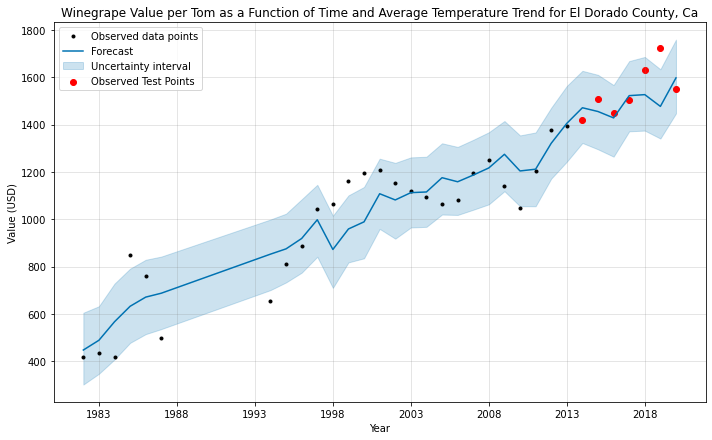

In [28]:
# Now to plot the testing segment on the test chart
model.plot(forecast, xlabel='Year', ylabel='Value (USD)')
plt.scatter(test['ds'], test['y'], c = 'red', label="Observed Test Points")
plt.legend()
plt.title('Winegrape Value per Tom as a Function of Time and Average Temperature Trend for El Dorado County, Ca')

The confidence onterval caught most of our test set data points.  
Now Let's predict into the future!

If using a regressor variable, like we are here with 'annual temperature', Prophet requires estimated values for
these to make a future prediction. We'll use the Stats Models to linearly predict the next five years annual mean
temperature values to provide this. 

In [29]:
# Make a fresh eldorado df (Statsmodels didn't like how we left the data column in eld_df)
eldorado_df = acc.loc[acc['county']=='ElDorado']
# Set a constant
X_withconstant = sm.add_constant(eldorado_df['year'])
y = eldorado_df['annual_temperature']
    
# Instantiate Linear regression model
myregression = sm.OLS(y, X_withconstant)
# Fit the model
myregression_results = myregression.fit()

# Predict the next five years onwards from 2020
years = np.array([2021, 2022, 2023, 2024, 2025])
future_years = sm.add_constant(years)
future_years = myregression_results.predict(future_years)

# Package this into a dataframe to append on to the Prophet forcast df
future_df = pd.DataFrame({'ds': years, 
              'annual_temperature': future_years})
future_df['ds'] = pd.to_datetime(future_df['ds'], format='%Y')

# Sort the dataframe just in case to the concat stacks in order
train_test_period_df = test_period.sort_values('ds')
forecast_df = pd.concat([train_test_period_df, future_df])

In [30]:
forecast_df.tail(10)

,ds,annual_temperature
4,2016-01-01,13.780000
3,2017-01-01,14.080000
2,2018-01-01,14.150000
1,2019-01-01,13.250000
0,2020-01-01,14.830000
0,2021-01-01,13.977115
1,2022-01-01,14.006182
2,2023-01-01,14.035249
3,2024-01-01,14.064315
4,2025-01-01,14.093382


Awesome. We're all set up to forcast El Dorodo's wine value by ton to 2025

<function matplotlib.pyplot.show(close=None, block=None)>

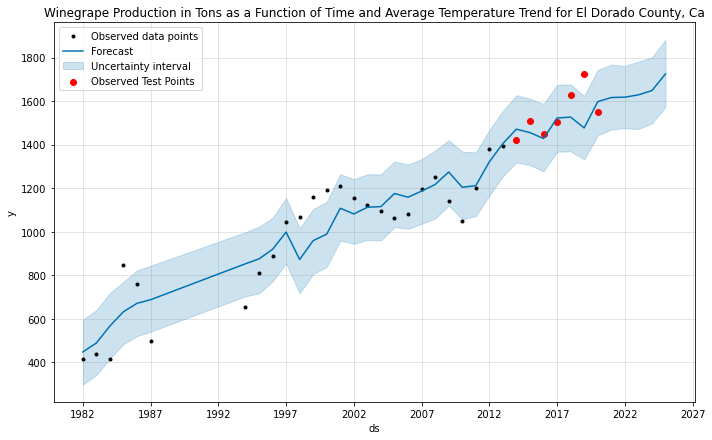

In [31]:
# Fire up our trained model
forecast = model.predict(forecast_df)
# Plot
fig2 = model.plot(forecast)
fig1 = plt.scatter(test['ds'], test['y'], c = 'red', label="Observed Test Points")
plt.legend()
plt.title('Winegrape Production in Tons as a Function of Time and Average Temperature Trend for El Dorado County, Ca')
plt.show

All else held constant, with time and average temperature trends, it looks like the price per ton for El Dorado Winegrapes will climb. Is this just the effect of inflation? That's a question for further analysis. 

Get this into a function were we can just punch in the county, and additional regressor variable to generate these prediction charts:

In [45]:
def visualize_wine_trend(county, climate_feat, dep_var):
    '''
    Input:
        county: One of the wine producing counties in the cwp dataset
        climate_feature: One of the climate featue column headers in the acc dataset
        dep_var: either "production" for tons of winegrapes produced in a given year
            or "price" for price value per ton of wine grapes for a given year
    
    Output: 
        a Prophet chart showing the relevant known datapoints in black, known test-set
        datapoints in red, and a prediction line running through to 2025, surrounded by
        a 80% error margin. 
    '''
    # String formatting for the chart title
    if dep_var == 'production':
        title_str = 'production in tons'
    elif dep_var == 'price':
        title_str = 'value per ton (usd)'
    
    ## Isolate the production and climate data for the selected county
    county_df = cwp_acc.loc[cwp_acc['county'] == county]

    # Format for Prophet
    county_df = county_df[['year', dep_var, climate_feat]]
    county_df['year'] = pd.to_datetime(county_df['year'], format='%Y')
    county_df.rename(columns={'year':'ds', dep_var:'y'}, inplace=True)

    # Test train split
    train = county_df.loc[county_df.ds < '2014']
    test = county_df.loc[county_df.ds >= '2014']

    # Train Prophet model
    model = Prophet() 
    model.add_regressor(climate_feat, standardize=True) 
    model.fit(train)

    # Construct the train_test_period_df
    # Set up a dataframe for the testing time segment so it includes 2014 onwards
    train_test_period = model.make_future_dataframe(periods=7, freq='Y')
    # update future df with column for the regressor amount-- annual_temperature
    train_test_period = train_test_period.merge(county_df[['ds', climate_feat]], on = ['ds'], how = 'right')

    ## Extend the dataframe to predict out to 2025
    # Set up a new dataframe to in a linear model prediction on the chosen 
    # climate feature
    county_df = cwp_acc.loc[cwp_acc['county'] == county]
    X_withconstant = sm.add_constant(county_df['year'])
    y = county_df[climate_feat]

    # Setup linreg
    myregression = sm.OLS(y, X_withconstant)
    # Fit the model
    myregression_results = myregression.fit()
    # predict the next five years onwards from 2020
    years = np.array([2021, 2022, 2023, 2024, 2025])
    future_years = sm.add_constant(years)
    future_years = myregression_results.predict(future_years)

    #package this into a dataframe to append on to the Prophet forcast df
    future_df = pd.DataFrame({'ds': years, 
                  climate_feat: future_years})
    future_df['ds'] = pd.to_datetime(future_df['ds'], format='%Y')

    # sort the dataframe just in case to the concat stacks in order
    train_test_period = train_test_period.sort_values('ds')

    # Concat the new forcast df segment onto the train_test_period df
    forecast_df = pd.concat([train_test_period, future_df])


    # Fire up the trained Prophet model
    forecast = model.predict(forecast_df)

    # Plot the output
    fig2 = model.plot(forecast, xlabel='YEAR', ylabel = dep_var.upper())
    fig1 = plt.scatter(test['ds'], test['y'], c = 'red', label="Observed Test Points")
    plt.legend(loc='upper left')
    plt.title(f'Winegrape {title_str} as a function of time and {climate_feat.replace("_"," ")} for {county} County, Ca')

Solano county's production volume is sensitive to average summer wind speed, so I'll use the model to do a time series forecast, factoring in that climate trend:

In [ ]:
# Make selections:
county = 'Solano'
climate_feat = 'summer_wind_speed'
dep_var = 'production'

visualize_wine_trend(county, climate_feat, dep_var)

Likewise, we identified the production value of Alameda county to be sensitive to summer humidity, so let's also forecast that:

19:23:08 - cmdstanpy - INFO - Chain [1] start processing
19:23:08 - cmdstanpy - INFO - Chain [1] done processing


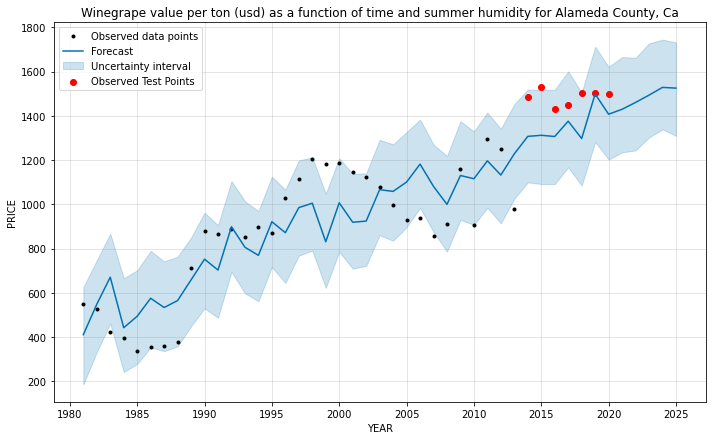

In [47]:
# Make selections
county = 'Alameda'
climate_feat = 'summer_humidity'
dep_var = 'price'

visualize_wine_trend(county, climate_feat, dep_var)

<a id="pts"></a>
### 4. Can we use flavor descriptor word tokens to predict if a review is going to be over 90pts?

In this section we use the tokenized words from the EDA notebook to create a model to predict if a wine will get a good review (above 90pts) just based on the presence of certain tokens. 